In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Module

import matplotlib.pyplot as plt

Решени задачи с Kaggle https://www.kaggle.com/competitions/sentiment-analysis-of-financial-news-headlines/leaderboard?tab=public

**Sentiment Analysis of Financial News Headlines**

Набор данных состоит из заголовков новостных лент и комментариев НА РУССКОМ с популярных платформ в отношении финансовых организаций и компаний, торгующихся на бирже.

Задача определения тональности текстовых фрагментов, полученных из новостных лент и комментариев, в отношении финансовых организаций и компаний, торгующихся на бирже.

Принимаем на вход текстовый фрагмент и выдаем:
1) в отношении какой компании направлено высказывание;
2) сентимент.

# Данные

## Обзор

train.csv - файл с обучающей выборкой, содержащий столбцы id, text, sber, vtb, gazprom, alfabank, raiffeisen, rshb, company.
- id - идентификатор сообщения
- text - текст сообщения
- Столбцы sber, vtb, gazprom, alfabank, raiffeisen, rshb содержат сентимент, связанный с упоминанием в тексте соответствующих банков: "Сбер", ВТБ, Газпромбанк, Альфа-банк, Райффайзенбанк, Россельхозбанк.
- Столбец company содержит сентимент в отношении одной из компаний, тогрующихся на Мосбирже и СПб бирже.

Возможные значения сентиментов:
-1 негативный;
1 позитивный;
0 нейтральный;
NULL текст не имеет отношения к соответствующему банку или компании

test.csv - файл с тестовой выборкой, содержащий столбцы id, text

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_FN.csv to test_FN.csv
Saving train_FN.csv to train_FN.csv


In [ ]:
!ls

sample_data  test_FN.csv  train_FN.csv


In [ ]:
df_train = pd.read_csv("train_FN.csv", delimiter=';')   # encoding='utf-8-sig'
df_test = pd.read_csv("test_FN.csv", delimiter=';')
df_train

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7156,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7158,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7159,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN


Глянем сколько пропусков

In [ ]:
df_train.isna().sum()

id               0
text             0
sber          3817
vtb           5683
gazprom       6757
alfabank      6507
raiffeisen    6888
rshb          6693
company       6418
dtype: int64

In [ ]:
df_train.dtypes

id              int64
text           object
sber          float64
vtb           float64
gazprom       float64
alfabank      float64
raiffeisen    float64
rshb          float64
company       float64
dtype: object

Столбец company содержит сентимент в отношении одной из компаний, тогрующихся на Мосбирже и СПб бирже.
- Много неточностей

In [ ]:
df_train[pd.notna(df_train['company'])].text[30:50].values

array(['Рынок акций РФ начал неделю с роста во главе с Аэрофлотом, индекс МосБиржи подня',
       'Ракета Astra Space вновь не смогла вывести спутники NASA на орбиту',
       'ЛУКОЙЛ В 2022Г УВЕЛИЧИЛ ДОБЫЧУ УГЛЕВОДОРОДОВ БЕЗ УЧЕТА ЗАПАДНОЙ КУРНЫ-2 НА 7%, Д',
       '«НОВАТЭК» может стать лидером по дивдоходности',
       'Акции "НОВАТЭКа" могут продолжить рост в апреле ближе к дате отсечки',
       'Роснедра поставили на госбаланс запасы крупного нефтегазового месторождения "ЛУКОЙЛа"',
       'Австрийский партнер «Газпрома» списал €1 млрд из-за «Северного потока-2»',
       'Россети Волга в 2022г получила 471,5 млн руб. чистого убытка по МСФО против пр',
       '«ЛУКОЙЛ» завершил сделку по продаже ООО «Информ»',
       'КОЭФФИЦИЕНТ ВОСПОЛНЕНИЯ ДОБЫЧИ ЛУКОЙЛА ПРИРОСТОМ ЗАПАСОВ В 2022Г СОСТАВИЛ 144% -',
       'NYT узнала о плане Маска увеличить доход Twitter в пять раз',
       'ММК - на пути восстановления',
       'СОВЕТ ДИРЕКТОРОВ ММК РЕКОМЕНДОВАЛ НЕ ВЫПЛАЧИВАТЬ ДИВИДЕНДЫ ПО ИТОГАМ 2

In [ ]:
list_company = ['лукойл','apple', 'россети сибирь','veon','аэрофлот', 'победа', 'новатэк', 'газпром']

## Чистка и обработка текста

In [ ]:
!pip install nltk

In [ ]:
import re   # для удаления лишних символов
import nltk  # лемматизатор и токенизатор
# from pymystem3 import Mystem


from nltk.corpus import stopwords
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize


# Загрузка доп данных
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Обработчик текста

In [ ]:
# Попробуем разные варианта обработки текста
def preprocess_text(text, lemmatize=False, stemming=False):

    text = re.sub(r'<.*?>', '', text)   # Удаление HTML-тегов
    # print('HTML done')


    text = re.sub(r'#', ' #', text)
    # Удаление хэштегов, за исключением следующих
    keywords = ['росси', 'втд', 'сбер', 'альфа', 'газпром', 'райф', 'россельхоз']
    hashtag_pattern = re.compile(r'#\w+')

    def should_remove(hashtag):
        return not any(keyword in hashtag.lower() for keyword in keywords)
    hashtags = hashtag_pattern.findall(text)
    for hashtag in hashtags:
        if should_remove(hashtag):
            text = text.replace(hashtag, '')
    # print('# done')


    text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)  # Удаление символов кроме букв и пробелов
    # print('cleaning done')


    text = text.lower()   # нижний регистр
    # print('lower done\n')


    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов


    # Токенизация
    words = word_tokenize(text, language="russian")

    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian'))
    words = [word for word in words if word not in stop_words]


    # Лемматизация и стемминг
    if lemmatize:
        mystem = Mystem()
        words = mystem.lemmatize(' '.join(words))
        words = [word for word in words if word.strip()]  # Удаление лишних пробелов
    elif stemming:
        stemmer = SnowballStemmer("russian")
        words = [stemmer.stem(word) for word in words]

    return words

In [ ]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stemming=False))
df_test['cleaned_text'] = df_test['text'].apply(lambda x: preprocess_text(x, lemmatize=False, stemming=False))

Лемматизация занимает слишком много времени

In [ ]:
index = 11
print("было:\n", df_train.text[index],'\n')
print("стало:\n",df_train.cleaned_text[index])

было:
 Донское вперед!) #сбербанквижн#донскоеотделение#донское#отделение#сбербанкроссии#сбербанк#россии 

стало:
 ['донское', 'вперед', 'сбербанквижн', 'сбербанкроссии', 'сбербанк', 'россии']


## Векторизация

Поскольку воспользоваться готовой моделью word2vec из проекта RusVectores не удается по причине того, что формат слов следующий: слово_[часть речи] обучим собственную модель

In [ ]:
# import gensim.downloader
# word2vec_model = gensim.downloader.load('word2vec-ruscorpora-300')

In [ ]:
''' Векторизация через CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
'''

In [ ]:
!pip install gensim

Обучение модели word2vec

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    min_count=1,      # сколько раз слово должно встретиться в корпусе, чтобы быть учтенным при обучении модели
    window=4,         # размер окна контекста вокруг каждого слова
    workers=3,        # количество ядер процессора, которые будут использоваться для обучения модели параллельно
    vector_size=100,  # размерность векторов слов
    negative=10,
    alpha=0.03,       # скорость обучения
    min_alpha=0.0007,
    sample=1e-4,
    sg=0)             # skip-gram при (sg=1)      CBOW при (sg=0)


w2v_model.build_vocab(df_train['cleaned_text'])   # получаем словарь
w2v_model.train(df_train['cleaned_text'], total_examples=w2v_model.corpus_count, epochs=120, report_delay=1)

(3591948, 5687640)

In [ ]:
w2v_model.wv.most_similar(positive=["банк"])

[('читает', 0.6988315582275391),
 ('тиньков', 0.6817579865455627),
 ('банке', 0.6765863299369812),
 ('наличными', 0.6748138070106506),
 ('райфайзенк', 0.6719266176223755),
 ('альфа', 0.6657472252845764),
 ('отечественные', 0.6639155149459839),
 ('абакан', 0.6614674925804138),
 ('льготные', 0.6593451499938965),
 ('колькулятор', 0.6591356992721558)]

Векторное представление слова

In [ ]:
w2v_model.wv.word_vec("банк")

<ipython-input-48-bac4435a848e>:1: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  w2v_model.wv.word_vec("банк")


array([-0.26771498,  0.18386567, -0.5536025 ,  0.16765171,  0.27953342,
       -0.31010178,  0.61913335,  0.26624826, -0.6878592 ,  0.5403125 ,
        0.4064246 , -0.8910554 ,  0.27103853,  0.06990933,  0.60347545,
        0.14256923, -0.37602678, -0.08842612, -0.357861  , -0.8078348 ,
       -1.2943857 , -0.25405455,  0.7092112 , -0.02825184, -0.1388523 ,
       -0.26755813,  0.7132662 ,  0.3434043 , -0.33889827, -0.8883199 ,
        0.16819125, -0.43476638,  0.28667754, -0.45858538, -0.6545841 ,
        0.97854203,  0.36601734, -0.26772407,  0.07942072, -0.6822371 ,
       -0.4325681 , -0.28782493, -0.07554755,  0.06207141,  0.36150348,
       -0.0066282 , -0.20885469, -0.78372663, -0.23792763,  0.4525091 ,
        0.2984695 , -0.01005645, -0.8095249 , -0.3169715 , -0.47163174,
        0.05931226,  0.67185175, -0.2858688 , -0.36322403,  0.62145257,
        0.11606842,  0.65021473, -0.13197064, -0.76294   , -0.93026793,
       -0.06419273,  0.27640486, -0.30947682, -0.37168366,  0.00

Визуализация

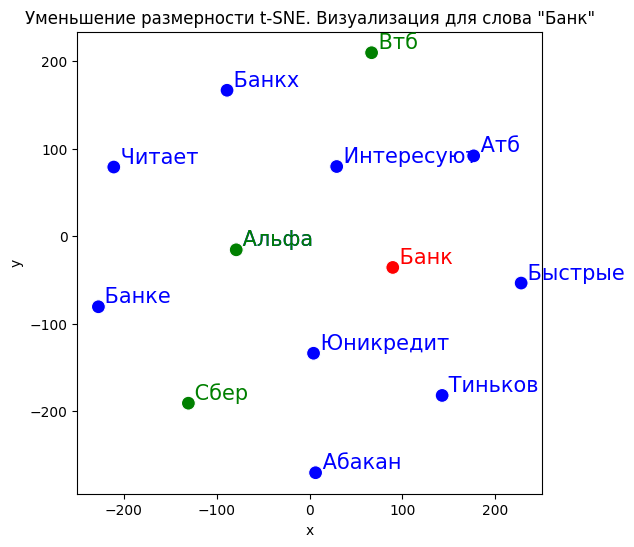

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def vector_representation_tsne(model, word, list_words):
    # Получаем список ближайших слов к входному слову
    close_words = model.wv.most_similar(word)

    # Списки для векторов и меток
    vectors_words = []
    word_labels = []
    color_list = []

    vectors_words.append(model.wv[word])
    word_labels.append(word)
    color_list.append('red')

    # Добавляем ближайшие слова
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # Добавляем слова из входного списка
    for wrd in list_words:
        if wrd in model.wv:
            wrd_vector = model.wv[wrd]
            vectors_words.append(wrd_vector)
            word_labels.append(wrd)
            color_list.append('green')



    # Уменьшаем размерность с помощью t-SNE
    vectors_words = np.array(vectors_words)
    tsne_model = TSNE(n_components=2, random_state=0, perplexity=min(15, len(vectors_words) - 1), init="pca")
    Y = tsne_model.fit_transform(vectors_words)


    # Создаем DataFrame для визуализации
    df = pd.DataFrame({
        "x": Y[:, 0],
        "y": Y[:, 1],
        "words": word_labels,
        "color": color_list
    })

    # Построение графика
    fig, _ = plt.subplots()
    fig.set_size_inches(6, 6)

    p1 = sns.scatterplot(data=df, x="x", y="y", hue="color", palette=["red", "blue", "green"], s=100, legend=False)
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line], df["y"][line], " " + df["words"][line].title(),
                horizontalalignment="left", verticalalignment="bottom", size="medium",
                color=df["color"][line], weight="normal").set_size(15)

    plt.title(f'Уменьшение размерности t-SNE. Визуализация для слова "{word.title()}"')
    plt.show()



main_word = 'банк'
list_words = ['альфа', 'сбер', 'втб']
vector_representation_tsne(w2v_model, main_word, list_words)

In [ ]:
'''  Вычисление среднего вектора по всем словам  '''

def get_word2vec_one_vector(words, model, size=100):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(size)
    return np.mean(vectors, axis=0)



'''  Конкатенация векторов слов для каждого текста   '''

def get_word2vec_concatenated_vectors(words, model, size=100, max_words=100):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(size * max_words)
    if len(vectors) < max_words:
        vectors.extend([np.zeros(size)] * (max_words - len(vectors)))
    else:
        vectors = vectors[:max_words]
    concatenated_vectors = np.concatenate(vectors)
    return concatenated_vectors


df_train['vectorized_text'] = df_train['cleaned_text'].apply(lambda x: get_word2vec_one_vector(x, w2v_model))
df_test['vectorized_text'] = df_test['cleaned_text'].apply(lambda x: get_word2vec_one_vector(x, w2v_model))

In [ ]:
def get_sentiment(row):
    for column in ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb', 'company']:
        if not pd.isna(row[column]):
            return row[column]
    return np.nan

df_train['sentiment'] = df_train.apply(get_sentiment, axis=1).fillna(100).astype(int)  # колонка ответов

In [ ]:
import json
# Сериализация колонки vectorized_text
df_train['vectorized_text'] = df_train['vectorized_text'].apply(lambda x: json.dumps(x.tolist()))
df_test['vectorized_text'] = df_test['vectorized_text'].apply(lambda x: json.dumps(x.tolist()))


df_train.to_csv('final_df_train.csv', index=False)
df_test.to_csv('final_df_test.csv', index=False)

files.download('final_df_train.csv')
files.download('final_df_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Подготовка выборки

In [ ]:
from google.colab import files
uploads = files.upload()

Saving final_df_test.csv to final_df_test.csv
Saving final_df_train.csv to final_df_train.csv


In [ ]:
import json
# Десериализация vectorized_text после загрузки
df_train['vectorized_text'] = df_train['vectorized_text'].apply(lambda x: np.array(json.loads(x)))
df_test['vectorized_text'] = df_test['vectorized_text'].apply(lambda x: np.array(json.loads(x)))


df_train = pd.read_csv("final_df_train.csv")
df_test = pd.read_csv("final_df_test.csv")

In [ ]:
'''   Для моделей типа решающих деревьев '''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train = np.stack(df_train['vectorized_text'].values)
X_test = np.stack(df_test['vectorized_text'].values)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['sentiment'])

X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [ ]:
'''   Для моделей типа LSTM  '''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X_train = np.stack(df_train['vectorized_text'].values)
X_test = np.stack(df_test['vectorized_text'].values)


encoder = OneHotEncoder(categories='auto', sparse=False)
y_onehot = encoder.fit_transform(df_train['sentiment'].values.reshape(-1, 1))

X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train, y_onehot, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Модель

Схема работы: обучим модель определять тональность текста, после чего поставим метку в нужные колонки

- xgboost и catboost требуют входных матриц размерности 2, причем одинаковой длины, поэтому в данном случае нужно использовать усреднение вектора ответа, а не конкатенацию
- BERT и LSTM можно юзать в любой длиной вектора

## XGBoost + Catboost

In [ ]:
df_train

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,cleaned_text,vectorized_text,sentiment
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,"['сбербанк', 'втб', 'пообещали', 'выполнить', ...",[-0.48313808 0.0057685 0.01037525 ... 0. ...,1
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['корея', 'стать', 'следующей', 'японией', 'ин...",[0.2241281 0.08299416 0.09418392 ... 0. ...,100
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,"['санкции', 'затрагивают', 'газпромбанк']",[-0.53362513 -1.38743877 -1.0411253 ... 0. ...,-1
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,"['заявила', 'обесценивании', 'бизнеса', 'росси...",[-0.13998351 0.3467325 0.07612921 ... 0. ...,-1
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,"['банк', 'втб', 'ипотечный', 'кредит']",[-0.7256757 0.371562 -0.33939758 ... 0. ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7156,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN,"['твиттера', 'сбербанка', 'тысчитателейвтб', '...",[0.14838178 0.26732945 0.25424215 ... 0. ...,0
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,"['заместителя', 'руководителя', 'пошёл', 'повы...",[-0.58425671 -0.52961987 0.56176001 ... 0. ...,0
7158,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN,"['оформить', 'кредитную', 'карту', 'альфа', 'б...",[-0.39655721 0.08865715 -0.18893817 ... 0. ...,0
7159,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN,"['кредиты', 'малого', 'бизнеса', 'втб', 'г', '...",[-0.12332558 -0.12029693 0.27058709 ... 0. ...,0


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.0 MB/s eta 0:00:00


Обучение

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_, y_train_)

y_pred = model.predict(X_valid_)
f1 = f1_score(y_valid_, y_pred, average='weighted')

print(f"Weighted F1 = {f1}")
print(classification_report(y_valid_, y_pred, zero_division=0))

Weighted F1 = 0.7744176336491164
              precision    recall  f1-score   support

           0       0.73      0.61      0.67       241
           1       0.83      0.92      0.87       916
           2       0.57      0.50      0.53       212
           3       0.97      0.45      0.62        64

    accuracy                           0.78      1433
   macro avg       0.77      0.62      0.67      1433
weighted avg       0.78      0.78      0.77      1433



In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y)  # после получения метрик тренеруем на всем наборе данных

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.01, loss_function='MultiClass', verbose=False)
catboost_model.fit(X_train_, y_train_)

y_pred_catboost = catboost_model.predict(X_valid_)
f1_catboost = f1_score(y_valid_, y_pred_catboost, average='weighted')

print(f"CatBoost Weighted F1 = {f1_catboost}")
print("CatBoost Classification Report")
print(classification_report(y_valid_, y_pred_catboost, zero_division=0))

CatBoost Weighted F1 = 0.7229991900662424
CatBoost Classification Report
              precision    recall  f1-score   support

           0       0.67      0.52      0.59       241
           1       0.79      0.92      0.85       916
           2       0.54      0.42      0.47       212
           3       1.00      0.16      0.27        64

    accuracy                           0.74      1433
   macro avg       0.75      0.51      0.55      1433
weighted avg       0.74      0.74      0.72      1433



Для учета дисбаланса классов зададим веса, пропорциональные обратной частоте классов в выборке

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_), y=y_train_)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.6254256526674233, 1: 0.38360567907848914, 2: 1.6107986501687288, 3: 6.364444444444445}


In [ ]:
catboost_model = CatBoostClassifier(iterations=2000, depth=8, learning_rate=0.01, loss_function='MultiClass', class_weights=class_weights, verbose=False)
catboost_model.fit(X_train, y)  # после получения метрик тренеруем на всем наборе данных

Предсказания

In [ ]:
df_test_catboost = df_test.copy()

y_test_pred = model.predict(X_test)
y_test_pred_original = label_encoder.inverse_transform(y_test_pred)
df_test['sentiment'] = y_test_pred_original


y_test_catboost_pred = catboost_model.predict(X_test)
y_test_pred_catboost_original = label_encoder.inverse_transform(y_test_catboost_pred)
df_test_catboost['sentiment'] = y_test_pred_catboost_original

Теперь проанализируем текст еще раз чтобы найти упомнания нужных банков

In [ ]:
banks = ['сбер', 'втб', 'газпромбанк', 'альфа', 'райффайзенбанк', 'россельхозбанк']
sentiments = ['n', '0', 'p']
banks_col = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb']
list_company = ['лукойл', 'apple', 'россети сибирь', 'veon', 'аэрофлот', 'победа', 'новатэк', 'газпром']


for bank in banks_col:
    for sentiment in sentiments:
        df_test[f'{bank}_{sentiment}'] = 0
        df_test_catboost[f'{bank}_{sentiment}'] = 0
for sentiment in sentiments:
    df_test[f'company_{sentiment}'] = 0
    df_test_catboost[f'company_{sentiment}'] = 0

def update_bank_columns(row):
    text = row['cleaned_text']
    prediction = row['sentiment']

    for bank_idx, bank in enumerate(banks):
        pattern = re.compile(r'\b' + re.escape(bank) + r'\w*\b')
        if pattern.search(text):
            if prediction == -1:
                row[f'{banks_col[bank_idx]}_n'] = 1
            elif prediction == 0:
                row[f'{banks_col[bank_idx]}_0'] = 1
            elif prediction == 1:
                row[f'{banks_col[bank_idx]}_p'] = 1

    for company in list_company:
        pattern = re.compile(r'\b' + re.escape(company) + r'\w*\b')
        if pattern.search(text):
            if prediction == -1:
                row[f'company_n'] = 1
            elif prediction == 0:
                row[f'company_0'] = 1
            elif prediction == 1:
                row[f'company_p'] = 1

    return row

df_test = df_test.apply(update_bank_columns, axis=1)
df_test_catboost = df_test_catboost.apply(update_bank_columns, axis=1)

In [ ]:
df_train[pd.notna(df_train['company'])][['cleaned_text','sentiment']].head(20)

,cleaned_text,sentiment
3,"[заявила, обесценивании, бизнеса, россии, млн,...",-1
12,"[остановил, смену, юрисдикции, бермудских, ост...",-1
28,"[золоту, хватает, самосвалов, отчитался, влиян...",-1
29,"[россети, сибирь, получили, чистый, убыток, мс...",-1
58,"[дивиденды, лукойла, оказались, немного, ниже,...",0
73,"[новатэк, одна, топовых, идей, год]",1
83,"[впервые, оштрафовали, отказ, локализовать, да...",-1
93,"[лукойл, г, увеличил, переработку, нефти, млн,...",0
107,"[роснедра, утвердили, запасы, нового, месторож...",0
118,"[узнал, плане, сократить, найм, сотрудников]",-1


In [ ]:
df_test.drop(columns = ['text', 'cleaned_text', 'vectorized_text', 'sentiment'], inplace=True)
df_test_catboost.drop(columns = ['text', 'cleaned_text', 'vectorized_text', 'sentiment'], inplace=True)

In [ ]:
df_test.columns

Index(['id', 'sber_n', 'sber_0', 'sber_p', 'vtb_n', 'vtb_0', 'vtb_p',
       'gazprom_n', 'gazprom_0', 'gazprom_p', 'alfabank_n', 'alfabank_0',
       'alfabank_p', 'raiffeisen_n', 'raiffeisen_0', 'raiffeisen_p', 'rshb_n',
       'rshb_0', 'rshb_p', 'company_n', 'company_0', 'company_p'],
      dtype='object')

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv", delimiter=',')
sample_submission.columns

Index(['id', 'sber_n', 'sber_0', 'sber_p', 'vtb_n', 'vtb_0', 'vtb_p',
       'gazprom_n', 'gazprom_0', 'gazprom_p', 'alfabank_n', 'alfabank_0',
       'alfabank_p', 'raiffeisen_n', 'raiffeisen_0', 'raiffeisen_p', 'rshb_n',
       'rshb_0', 'rshb_p', 'company_n', 'company_0', 'company_p'],
      dtype='object')

Поскольку kaggle выдает ошибку несоответствия строк, найдем индексы, которые есть в submission, но нет в test (кринж)

In [ ]:
!ls

df_test_xgb_1.csv  final_df_train.csv  sample_submission.csv
final_df_test.csv  sample_data	       test_FN.csv


In [ ]:
df_test['id'] = df_submission['id']
df_test_catboost['id'] = df_submission['id']

In [ ]:
def cringe(df_test_FN, df_submission):
    ids_test_FN = set(df_test_FN['id'])
    ids_submission = set(df_submission['id'])

    missing_ids_in_submission = ids_submission - ids_test_FN
    missing_rows = pd.DataFrame({'id': list(missing_ids_in_submission)})
    missing_rows = missing_rows.assign(**{col: 0 for col in df_test_FN.columns if col != 'id'})

    df_test_FN = pd.concat([df_test_FN, missing_rows], ignore_index=True)
    df_test_FN = df_test_FN.sort_values(by='id').reset_index(drop=True)
    return df_test_FN

df_submission = pd.read_csv('sample_submission.csv')
df_test = cringe(df_test, df_submission)
df_test_catboost = cringe(df_test_catboost, df_submission)

In [ ]:
df_test_catboost

,id,sber_n,sber_0,sber_p,vtb_n,vtb_0,vtb_p,gazprom_n,gazprom_0,gazprom_p,...,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,company_n,company_0,company_p
0,2807,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5231,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9155,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2525,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7702,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4784,17995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4785,7571,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4786,6279,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.to_csv('df_test_xgb_2.csv', index=False)
df_test_catboost.to_csv('df_test_cat_1.csv', index=False)
files.download('df_test_xgb_2.csv')
files.download('df_test_cat_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import nltk
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
nltk.download('punkt')

# Преобразование всех значений в строки и удаление NaN
df_train['cleaned_text'] = df_train['cleaned_text'].astype(str).fillna('')


# список всех слов в текстах
all_words = [word for text in df_train['cleaned_text'] for word in word_tokenize(text, language="russian")]
vocab_size = len(set(all_words))  # размер словаря
max_sequence_length = max(len(word_tokenize(text)) for text in df_train['cleaned_text'])

'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['cleaned_text'])
'''

# Определяем максимальную длину последовательности
max_sequence_length = max([len(seq) for seq in tokenizer.texts_to_sequences(df_train['cleaned_text'])])



model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=100, input_length=100))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['f1_score'])
# X_train_reshaped = np.expand_dims(X_train_, axis=1)
# X_valid_reshaped = np.expand_dims(X_valid_, axis=1)
model.fit(X_train_, y_train_, validation_data=(X_valid_, y_valid_), epochs=10, batch_size=64)


y_pred = model.predict(X_valid_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_valid_classes = np.argmax(y_valid_, axis=1)

print(classification_report(y_valid_classes, y_pred_classes, zero_division=0))